# WEP Source Selection Without WCS

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2023-12-12**
<br>Software Versions:
  - `ts_wep`: **v8.0.3**
  - `lsst_distrib`: **w_2023_47**

## Notebook Objective

This notebooks shows how to use the `generateDonutCatalogOnlineTask` to create donut catalogs without a WCS and starting from pointing information for the visit. It also shows how to configure the task with different source selector configurations.

## Logistics

This notebook is intended to be run on the USDF RSP: https://usdf-rsp.slac.stanford.edu/.

### Data

The images for this notebook were created by from imSim simulations of the LSSTCam Corner Wavefront Sensors (CWFS) using the Pan-Starrs reference catalog (`ps1_pv3_3pi_20170110`) available in `/sdf/group/rubin/datasets/refcats/htm/v1` on the USDF. The raw imSim outputs including the OPD for analysis are found at `/sdf/home/b/brycek/u/aos-repos/aosTestDataRepoImsim/simulated_data`.

## Imports

In [1]:
from lsst.daf.butler import Butler
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig

from lsst.ts.wep.utils import runProgram, writePipetaskCmd
from lsst.ts.wep.task import RefCatalogInterface
from lsst.ts.wep.task import GenerateDonutCatalogOnlineTask, GenerateDonutCatalogOnlineTaskConfig
from lsst.ts.imsim import ObsMetadata

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

## Create `donutCatalog` as a single task before pipeline

In [2]:
# Repository with the raw data
butler_repo = '/sdf/group/rubin/u/brycek/aos-repos/aosTestDataRepoImsim/'

### Configure the `generateDonutCatalogOnlineTask`

In [3]:
# Initialize Configuration
config = GenerateDonutCatalogOnlineTaskConfig()

In [4]:
# Look at initial configuration
print(config)
print(config.keys())

{'filterName': 'g', 'donutSelector': {'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'useCustomMagLimit': False, 'magMax': 99.0, 'magMin': -99.0, 'maxFieldDist': 1.813, 'unblendedSeparation': 160, 'minBlendedSeparation': 120, 'isolatedMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, 'doDonutSelection': True}
dict_keys(['filterName', 'donutSelector', 'doDonutSelection'])


* `donutSelector`:

  * This is the subtask that performs cuts on the sources detected to get our donut sources.
  * This task is activated with `doDonutSelection`.
  * The default settings have `unblendedSeparation` equal to 160. This means that sources will be tagged as unblended as long as they are 160 pixels from another source within the `isolatedMagDiff`. The `isolatedMagDiff` default is 2.0. This means that if multiple sources are within the `unblendedSeparation` of each other but the brightest is at least `isolatedMagDiff` brighter in the filter than any of the others we will consider the brightest source unblended.
  * Here we will set a maximum number of sources to return in the catalog with `sourceLimit`. This will return the `n` brightest, unblended sources within our catalog settings up to `n = sourceLimit`. If `sourceLimit` is set to -1 (which is the default) then it will return all sources.
  * Finally we also set the number of stars that we will accept to be blended with the brightest star in a group (remember blended means the stars are within `unblendedSeparation` pixels of one another and their magnitudes are within `isolatedMagDiff`). When we set this config `maxBlended` to 0 we only accept unblended, isolated stars.

In [5]:
# Activate the subtask
config.doDonutSelection = True
# Turn on custom mag limits
config.donutSelector.useCustomMagLimit = True
# Set magnitude limits
config.donutSelector.magMax = 17.
config.donutSelector.magMin = 13.
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
config.donutSelector.isolatedMagDiff = 2.0
# Set the donut radius
config.donutSelector.unblendedSeparation = 160
# Set source limit
config.donutSelector.sourceLimit = 3
# Set the number of stars that can be blended with a star. A value of 0 here means we only take unblended stars.
config.donutSelector.maxBlended = 0
# Set the maximum distance (in degrees) a source can be from the center of the focal plane. This allows us
# to prevent vignetted sources from appearing in the catalog.
config.donutSelector.maxFieldDist = 1.85

## Create donut source catalogs

### Configure reference catalog input

Here we use the pointing information to only load the pieces of the reference catalog that cover the area of the sky in our field of view.

In [6]:
# Initialize with pointing information
boresightRa = 197.46
boresightDec = 24.33
boresightRotAng = 67.179
refCatInterface = RefCatalogInterface(boresightRa, boresightDec, boresightRotAng)

#### Get `shardIds` for pointing

In [7]:
%%time
htmIds = refCatInterface.getHtmIds()

CPU times: user 124 µs, sys: 18 µs, total: 142 µs
Wall time: 144 µs


In [8]:
htmIds

array([223876, 223889, 223890, 223891, 223896, 223897, 223898, 223899,
       223900, 223901, 223902, 223903, 223928, 223929, 223931, 224328,
       224353, 224356, 224358, 224359, 224366, 224372, 223877, 223878,
       223879, 223888, 223893, 223894, 223895, 223922, 223930, 223932,
       223933, 223935, 223952, 223954, 223955, 223961, 223965, 224329,
       224330, 224331, 224352, 224354, 224355, 224357, 224364, 224365,
       224367, 224373, 224374, 224375, 224382])

#### Get butler data references for the pieces of the reference catalogs we want

In [9]:
butler = Butler(butler_repo)
# Find the collection that holds the reference catalogs
list(butler.registry.queryCollections())

['refcats/ps1_pv3_3pi_20170110',
 'refcats/gaia_dr2_20200414',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTCam/calib/curated/19700101T000000Z',
 'LSSTCam/raw/all',
 'ts_wep_v8.0.3',
 'refcats']

In [10]:
collections = ['refcats/ps1_pv3_3pi_20170110']
catalogName = 'ps1_pv3_3pi_20170110'

In [11]:
%%time
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)

CPU times: user 168 ms, sys: 20 ms, total: 188 ms
Wall time: 294 ms


In [12]:
# The butler dataset references for the pieces of the reference catalog we want
dataRefs[:5]

[DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f9fd2f2ecd0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223876}, run='refcats/ps1_pv3_3pi_20170110', id=86815f9e-0b31-4e7b-b05b-09d7eaa035c2), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f9fd2f2ecd0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223889}, run='refcats/ps1_pv3_3pi_20170110', id=eff4cd62-9661-472a-8152-9bd6f13299e1), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f9fd2f2ecd0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223890}, run='refcats/ps1_pv3_3pi_20170110', id=90e2ecd2-65cb-4e94-b5b1-e122c573d75d), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler objec

#### Load camera from butler and run catalog creation task

In [13]:
# Load camera from butler to make sure we have latest version of instrument
camera = butler.get('camera', dataId={'instrument':'LSSTCam'}, collections=['LSSTCam/calib/unbounded'])

In [14]:
# Create task with our configuration from above
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [15]:
detExtra = camera['R04_SW0']
detWcsExtra = refCatInterface.getDetectorWcs(detExtra)

In [16]:
%%time
catExtra = catCreationTask.run(dataRefs, detExtra, detWcsExtra)

CPU times: user 125 ms, sys: 4.01 ms, total: 129 ms
Wall time: 131 ms


In [17]:
detIntra = camera['R04_SW1']
detWcsIntra = refCatInterface.getDetectorWcs(detIntra)

In [18]:
%%time
catIntra = catCreationTask.run(dataRefs, detIntra, detWcsIntra)

CPU times: user 56.3 ms, sys: 1.07 ms, total: 57.4 ms
Wall time: 57.4 ms


In [19]:
catExtra.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2729.979701,704.955433,1.390237e+07,[],[]
1,3.416295,0.435093,2256.179975,1736.637100,1.179842e+07,[],[]
2,3.414778,0.434399,3843.666257,1648.258139,1.590008e+06,[],[]


In [20]:
catIntra.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.417718,0.436853,3761.559755,1455.346854,4.787356e+06,[],[]
1,3.415339,0.435769,1275.591346,1592.323967,4.623140e+06,[],[]
2,3.414932,0.435764,923.702911,1444.228330,3.504352e+06,[],[]


Next let's get the images and take a look at the sources we keep as we change the configuration settings.

### Run ISR and get images

Before we go any further let's process some images so we can plot our catalogs on the images and see what our results look like at each step.

In [21]:
isrConfig = IsrTaskConfig()

In [22]:
isrConfig.doBias = False
isrConfig.doVariance = False
isrConfig.doLinearize = False
isrConfig.doCrosstalk = False
isrConfig.doDefect = False
isrConfig.doNanMasking = False
isrConfig.doInterpolate = False
isrConfig.doDark = False
isrConfig.doFlat = False
isrConfig.doApplyGains = True
isrConfig.doFringe = False
isrConfig.doOverscan = True

In [23]:
isrTask = IsrTask(config=isrConfig)

In [24]:
cwfsDataIdsExtra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=195, instrument='LSSTCam'))

In [25]:
cwfsDataIdsExtra

[{instrument: 'LSSTCam', detector: 195, exposure: 5022050101000, band: 'g', physical_filter: 'g_6'}]

In [26]:
cwfsDataIdsIntra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=196, instrument='LSSTCam'))

In [27]:
cwfsDataIdsIntra

[{instrument: 'LSSTCam', detector: 196, exposure: 5022050101000, band: 'g', physical_filter: 'g_6'}]

In [28]:
exposureExtra = butler.get('raw', dataId=cwfsDataIdsExtra[0], collections=['LSSTCam/raw/all'])

In [29]:
exposureIntra = butler.get('raw', dataId=cwfsDataIdsIntra[0], collections=['LSSTCam/raw/all'])

In [30]:
isrOutExtra = isrTask.run(exposureExtra)

In [31]:
isrOutIntra = isrTask.run(exposureIntra)

### Initial catalog configuration

Text(0.5, 1.0, 'Extra-focal Detector')

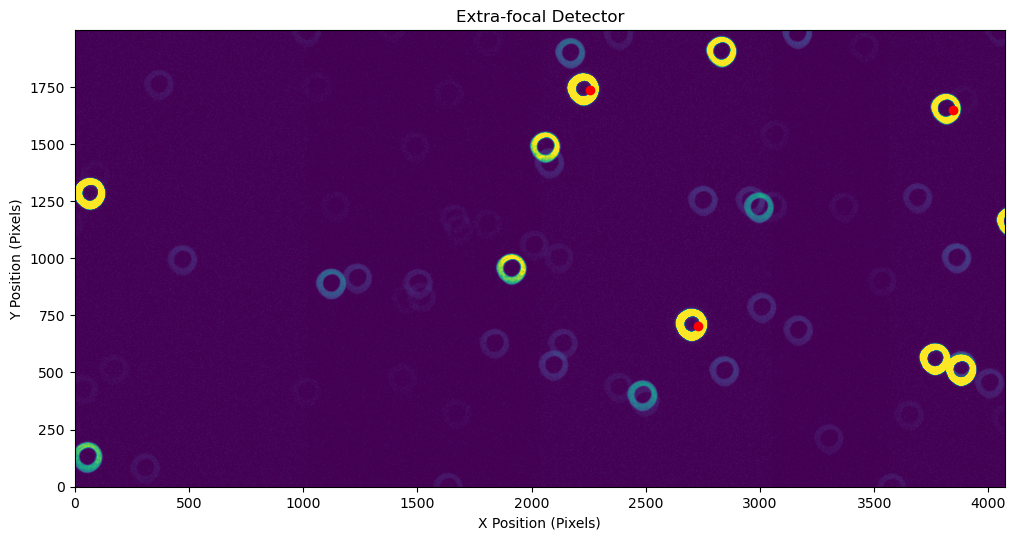

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=200, vmin=0, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.xlabel('X Position (Pixels)')
plt.ylabel('Y Position (Pixels)')
plt.title('Extra-focal Detector')

Text(0.5, 1.0, 'Intra-focal Detector')

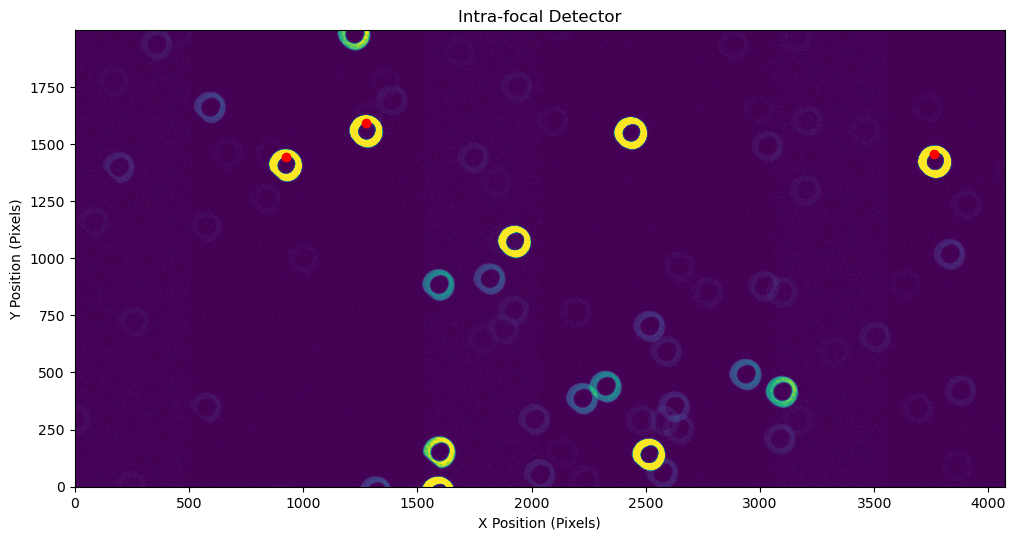

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutIntra.exposure.getImage().getArray(), vmax=200, vmin=0, origin='lower')
plt.scatter(catIntra.donutCatalog['centroid_x'], catIntra.donutCatalog['centroid_y'], c='r')
plt.xlabel('X Position (Pixels)')
plt.ylabel('Y Position (Pixels)')
plt.title('Intra-focal Detector')

### Show that our catalog changes as we change configurations

Let's change the configuration settings and see how our catalog changes.

#### Remove limit on number of sources

In [34]:
# Create task with our configuration from above but first turn off the sourceLimit parameter (set to -1).
config.donutSelector.sourceLimit = -1
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [35]:
%%time
catExtraNoSourceLimit = catCreationTask.run(dataRefs, detExtra, detWcsExtra)

CPU times: user 125 ms, sys: 1.95 ms, total: 127 ms
Wall time: 129 ms


In [36]:
catExtraNoSourceLimit.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2729.979701,704.955433,1.390237e+07,[],[]
1,3.416295,0.435093,2256.179975,1736.637100,1.179842e+07,[],[]
2,3.414778,0.434399,3843.666257,1648.258139,1.590008e+06,[],[]
3,3.416566,0.434932,2090.065712,1483.755095,1.052163e+06,[],[]
4,3.416938,0.434516,1942.177881,950.495824,9.297410e+05,[],[]


We see that we now have two more sources than we had when we limited the length of the returned catalog.

Text(0, 0.5, 'Y Position (Pixels)')

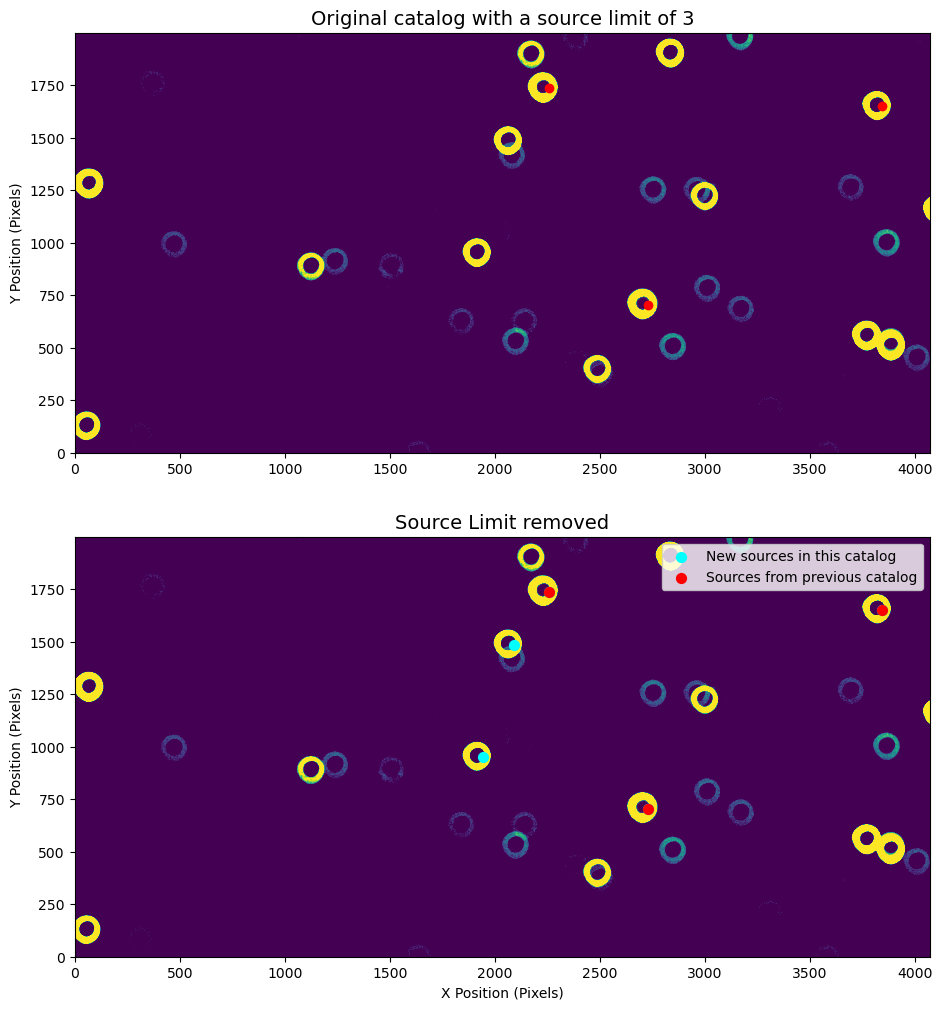

In [37]:
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(2,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(2,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Source Limit removed', size=14)
plt.xlabel('X Position (Pixels)')
plt.ylabel('Y Position (Pixels)')

Notice how the sources kept with the `sourceLimit` are the `sourceLimit` brightest sources.

#### Change magnitude limits

In [38]:
# Change magMax value to 19.0 from 17.0
config.donutSelector.magMax = 19.0
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [39]:
%%time
catExtraMagLimit19 = catCreationTask.run(dataRefs, detExtra, detWcsExtra)

CPU times: user 128 ms, sys: 2.93 ms, total: 131 ms
Wall time: 137 ms


In [40]:
catExtraMagLimit19.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2729.979701,704.955433,1.390237e+07,[],[]
1,3.416295,0.435093,2256.179975,1736.637100,1.179842e+07,[],[]
2,3.414778,0.434399,3843.666257,1648.258139,1.590008e+06,[],[]
3,3.416566,0.434932,2090.065712,1483.755095,1.052163e+06,[],[]
4,3.416938,0.434516,1942.177881,950.495824,9.297410e+05,[],[]
5,3.416613,0.433801,2515.344795,395.342967,4.340326e+05,[],[]
6,3.415012,0.433800,3890.008214,994.348588,1.512020e+05,[],[]
7,3.416217,0.433757,2873.452585,501.567049,1.376093e+05,[],[]
8,3.415991,0.434456,2780.062646,1247.767532,1.088828e+05,[],[]
9,3.415939,0.433939,3037.494272,778.655056,9.551228e+04,[],[]


Now we have a lot more sources. Let's check the magnitudes from each catalog to make sure the cuts are correct.

In [41]:
origCatalogMags = (catExtraNoSourceLimit.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)
newCatalogMags = (catExtraMagLimit19.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)

In [42]:
print(f"The original catalog had stars with magnitudes between {np.min(origCatalogMags)} and {np.max(origCatalogMags)}.\nThese are within the limits of 13.0 - 17.0 set by the task configuration.")

The original catalog had stars with magnitudes between 13.542277683868818 and 16.479095093743577.
These are within the limits of 13.0 - 17.0 set by the task configuration.


In [43]:
print(f"The new catalog has stars with magnitudes between {np.min(newCatalogMags)} and {np.max(newCatalogMags)}.\nThese are within the limits of 13.0 - 19.0 set by the task configuration.")

The new catalog has stars with magnitudes between 13.542277683868818 and 18.97681224516664.
These are within the limits of 13.0 - 19.0 set by the task configuration.


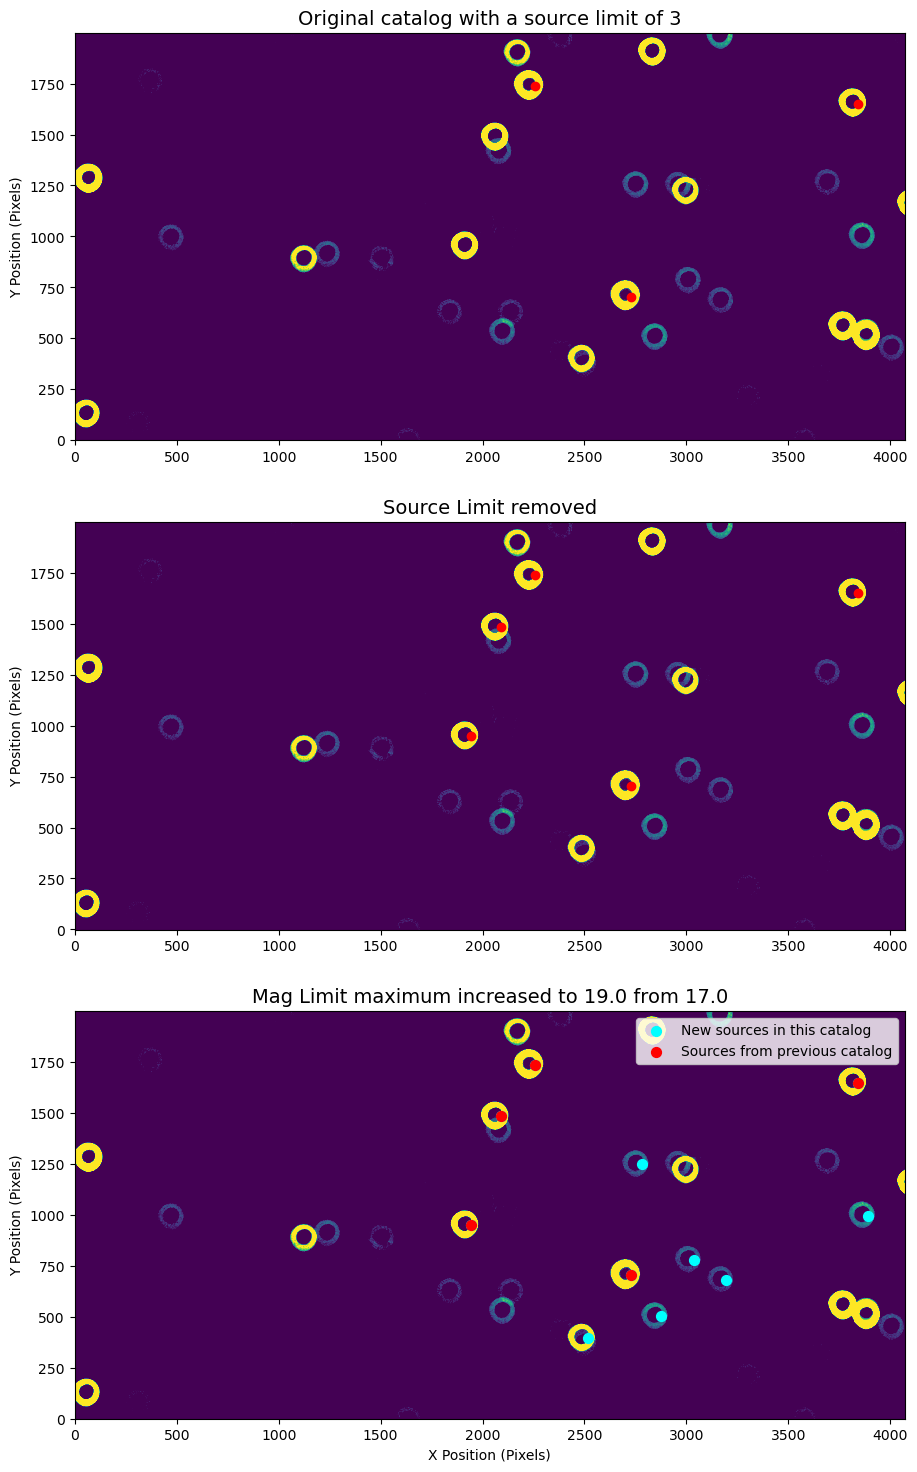

In [44]:
fig = plt.figure(figsize=(12, 18))
fig.add_subplot(3,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(3,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(3,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')
plt.legend()

#### Change isolated magnitude setting

Let's call stars unblended now if there are only 1 magnitude brighter than any overlapping stars.

In [45]:
# Change isoMagDiff to shrink the threshold for unblended down to only 1 magnitude brighther than overlapping stars
config.donutSelector.isolatedMagDiff = 1.0
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [46]:
%%time
catExtraIsoOneMag = catCreationTask.run(dataRefs, detExtra, detWcsExtra)

CPU times: user 129 ms, sys: 1.99 ms, total: 131 ms
Wall time: 133 ms


In [47]:
catExtraIsoOneMag.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2729.979701,704.955433,1.390237e+07,[],[]
1,3.416295,0.435093,2256.179975,1736.637100,1.179842e+07,[],[]
2,3.414778,0.434399,3843.666257,1648.258139,1.590008e+06,[],[]
3,3.416566,0.434932,2090.065712,1483.755095,1.052163e+06,[],[]
4,3.416938,0.434516,1942.177881,950.495824,9.297410e+05,[],[]
5,3.415763,0.434334,3025.199801,1217.793144,4.393951e+05,[],[]
6,3.416613,0.433801,2515.344795,395.342967,4.340326e+05,[],[]
7,3.417739,0.434764,1152.603347,886.412542,2.976980e+05,[],[]
8,3.415012,0.433800,3890.008214,994.348588,1.512020e+05,[],[]
9,3.416217,0.433757,2873.452585,501.567049,1.376093e+05,[],[]


This setting allowed two more stars to pass through into our catalog.

In [ ]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(4,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

Text(0.5, 0, 'X Position (Pixels)')

#### Change number of allowed blended stars

Finally allow stars blended with only one other star within the `unblendedSeparation` and `isolatedMagDiff` settings.

In [ ]:
# Change number of allowed stars blended with a target star to be 1 instead of 0
config.donutSelector.maxBlended = 1
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [ ]:
%%time
catExtraOneBlend = catCreationTask.run(dataRefs, detExtra, detWcsExtra)

In [ ]:
catExtraOneBlend.donutCatalog

Once again another source appears in our catalog.

In [ ]:
fig = plt.figure(figsize=(12, 30))
fig.add_subplot(5,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r')
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,5)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraOneBlend.donutCatalog['centroid_x'], catExtraOneBlend.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Allowed number of blended neighbors increased from 0 to 1.', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

#### Change allowed distance from center of the focal plane

Here we will look at the intra-focal detector and how we can limit donuts chosen to only be within a certain distance from the center of the focal plane. We want to be able to do this to avoid vignetted donuts in our catalogs if they turn out to cause issues with wavefront estimation.

In [ ]:
# Create task with our final configuration from the extra-focal detector that allows a large sample of sources.
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [ ]:
%%time
catIntraBaseline = catCreationTask.run(dataRefs, detIntra, detWcsIntra)

In [ ]:
catIntraBaseline.donutCatalog

We see that we have 13 sources in our baseline catalog. Now let's run the task limiting our sources to be within 1.75 degrees of the center of the focal plane.

In [ ]:
# Create task with our final configuration from the extra-focal detector that allows a large sample of sources.
config.donutSelector.maxFieldDist = 1.75
catCreationTask = GenerateDonutCatalogOnlineTask(config=config)

In [ ]:
%%time
catIntra1p75degrees = catCreationTask.run(dataRefs, detIntra, detWcsIntra)

In [ ]:
catIntra1p75degrees.donutCatalog

Now our catalog only has 10 sources that are within 1.75 degrees of the center of the focal plane. To verify that this is correct let's draw out the distance from the center of the focal plane as a series of contours and check that we have no sources outside 1.75 degrees from the center.

In [ ]:
# Create meshgrid for contours and calculate distance to center for points in grid
import lsst.geom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE

X, Y = np.meshgrid(np.arange(0, 4096, 5), np.arange(0, 2001, 5))
Z = np.zeros(np.shape(X))

for x_idx in np.arange(0, 4096, 5):
    for y_idx in np.arange(0, 2001, 5):
        # Use detector object to convert between Pixels and Field Angle
        field_xy = isrOutIntra.exposure.getDetector().transform(
            lsst.geom.Point2D(x_idx, y_idx), PIXELS, FIELD_ANGLE
        )
        field_dist = np.sqrt(field_xy[0]**2 + field_xy[1]**2)
        Z[int(y_idx/5), int(x_idx/5)] = np.degrees(field_dist)

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(2,1,1)
plt.imshow(isrOutIntra.exposure.getImage().getArray(), vmax=50, vmin=0, origin='lower')
plt.scatter(catIntraBaseline.donutCatalog['centroid_x'], catIntraBaseline.donutCatalog['centroid_y'], c='r')
plt.title('Baseline catalog', size=14)
plt.ylabel('Y Position (Pixels)')

ax = fig.add_subplot(2,1,2)
plt.imshow(isrOutIntra.exposure.getImage().getArray(), vmax=50, vmin=0, origin='lower')
C = plt.contour(X, Y, Z, cmap=plt.get_cmap('Reds'), levels=[1.65, 1.70, 1.75, 1.80, 1.85])
ax.clabel(C, inline=True, fontsize=12)
plt.scatter(catIntra1p75degrees.donutCatalog['centroid_x'], catIntra1p75degrees.donutCatalog['centroid_y'], c='r')
plt.title('Max Distance from Focal Plane set to 1.75 degrees', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

It looks like our sources are all the sources within the cutoff at 1.75 degrees and that the configuration setting is working as expected.